In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.ion() # (%matplotlib inline)
import os

# Patch Perfect

This notebook will document the process we underwent to find a solution to the plothole-problem.


### EDA

We start by looking at the data systematically to see where we will inevitably need to solve problems before we create a model:

In [4]:
# __file__ = os.path.abspath('') # notebooks are stupid
# DATA_DIR = Path(__file__).resolve() / "data"
# TRAIN_LABELS_PATH = DATA_DIR / "train_labels.csv"

# train_label_df = pd.read_csv(filepath_or_buffer=TRAIN_LABELS_PATH)
# train_label_df.rename(columns={'Bags used ': 'Bags used'}, inplace=True)

In [5]:
# values = train_label_df.loc[:, 'Bags used'].value_counts()
# plt.figure(figsize=(10, 6))
# plt.hist(values, bins=range(1, max(values) + 2), edgecolor='black')
# plt.title('Histogram of Data Points per Bag Amount')
# plt.xlabel('Number of Data Points for Each Bag Amount')
# plt.ylabel('Frequency')
# plt.grid(True)


We can see that there is a massive class imbalance. This could create issues where a model trained on this dataset has a bias towards more common bags. Most values are between 0 and 1 with some values much higher. There are many strategies we could use to solve this, including but not limited to:
<ul>
<li>Some label abstraction technique where we might create labels based on a logarithmic scale</li>
<li>Data augmentation as a class imbalance mitigation: This process is called upsampling</li>
</ul>

We should also consider the following: The data makes this problem seem like a regression model is needed, but tuning the labels may enable us to change it to a much simpler classification task at the cost of some accuracy. Doing this would result in a much more robust model and enable us to use techniques like label smoothing to let the model generalize more to unseen data.
<hr>
References:
<ul>
<li>Paperspace Blog. (2022). Data Augmentation: A Class Imbalance Mitigative Measure. [online] Available at: https://blog.paperspace.com/data-augmentation-a-class-imbalance-mitigative-measure/.</li>
<li>S. Wang and X. Yao, "Multiclass Imbalance Problems: Analysis and Potential Solutions," in IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 42, no. 4, pp. 1119-1130, Aug. 2012, doi: 10.1109/TSMCB.2012.2187280. keywords: {Training;Correlation;Training data;Pattern analysis;Genetic algorithms;IEEE Potentials;Cybernetics;Boosting;diversity;ensemble learning;multiclass imbalance problems;negative correlation learning}, </li>
</ul>
‌

## The model

In [6]:
import torch
from torch import nn
model = torch.load("./pretrained_model.pt")

for name, param in model.named_parameters():
    if("bn" not in name):
      param.requires_grad = False


model.classifier = nn.Sequential( # Change only the classifier of the model, I.E the last few layers

    nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1)) # Change the output to 3 classes instead of 21

)


/tmp/ipykernel_583706/3933020813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./pretrained_model.pt")


In [7]:
trainable_layers = 0
non_trainable_layers = 0

for name, module in model.named_modules():
    # Check if any parameter in the layer requires gradients
    if any(param.requires_grad for param in module.parameters()):
        trainable_layers += 1
    else:
        non_trainable_layers += 1

print(f"Trainable layers: {trainable_layers}")
print(f"Non-trainable layers: {non_trainable_layers}")


Trainable layers: 75
Non-trainable layers: 87


In [8]:

trainable_params = 0
non_trainable_params = 0

for param in model.parameters():
    if param.requires_grad:
        trainable_params += param.numel()  # Count the number of elements
    else:
        non_trainable_params += param.numel()

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Trainable parameters: 9485187
Non-trainable parameters: 25827797


## Training Code

In [9]:
import torch.optim as optim
from torchvision.utils import save_image


# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=0.001
# )



def train_model(model, train_loader, val_loader, num_epochs=1):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 3e-4) # Karpathy's number

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.type(torch.LongTensor).cuda()
                model.cuda()


            # Forward pass
            outputs = model(images)['out']

            loss = criterion(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            #running_loss += loss.item() * images.size(0)
        test_loss = evaluate_model(model, val_loader)
        #epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {test_loss:.4f}')

def evaluate_model(model, val_loader):
    model.eval()
    total_correct = 0
    total_pixels = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)['out']
            _, preds = torch.max(outputs, 1)

            total_pixels += labels.numel()
            total_correct += (preds == labels).sum().item()

        accuracy = total_correct / total_pixels
        return accuracy
        #print(f'Validation Accuracy: {accuracy:.4f}')


## Data Prep Code

In [10]:
# Custom dataset class for your data
import torchvision.transforms as transforms
import random

import torch
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np

rgb_to_class = {
    (0, 0, 0): 0,
    (255, 255, 255): 1,
    (100, 100, 100): 2
}

class JointTransform:
    def __init__(self, image_transforms=None, mask_transforms=None):
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
    @staticmethod
    def set_seed(seed):
      torch.manual_seed(seed)
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
      random.seed(seed)
      np.random.seed(seed)

      # Ensure that all operations are deterministic
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
    def __call__(self, image, mask):
        if self.image_transforms:
            seed = random.randint(0, 2**32)
            self.set_seed(seed)
            image = self.image_transforms(image)

            self.set_seed(seed)
            mask = self.mask_transforms(mask)

        return image, mask

image_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

mask_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

# Instantiate joint transform
augmentation = JointTransform(image_transforms=image_augmentations, mask_transforms=mask_augmentations)


class Potholes(Dataset):
    def __init__(self, image_dir, label_dir, do_augmentation = True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = os.listdir(image_dir)
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        self.do_augmentation = do_augmentation

    def __len__(self):
        return len(self.image_filenames)

    @staticmethod
    def rgb_to_mask(mask):
        # Convert the mask to a numpy array
        mask = np.array(mask)

        # Initialize an array to hold the class indices
        class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

        # Apply the mapping from RGB values to class indices
        for rgb, class_index in rgb_to_class.items():
            matches = np.all(mask == rgb, axis=-1)
            class_mask[matches] = class_index

        return class_mask

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, (img_name[:-4] + "_mask.png"))

        # Load image and label
        image = Image.open(img_path)
        mask = Image.open(label_path).convert("RGB")

        # Apply augmentations then transformations

        if self.do_augmentation: image, mask = augmentation(image, mask)

        image, mask = self.image_transforms(image, mask)

        return image, mask

# Define transforms for data augmentation and normalization

    def image_transforms(self, image, label):
        transform_images = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to the desired input size
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

        transform_labels = transforms.Compose([
            transforms.Resize((256, 256))
        ])
        mask = self.rgb_to_mask(transform_labels(label))
        return transform_images(image), mask




# Paths to your dataset
train_image_dir = "./data/train_images_segmented/"
train_label_dir = "./data/train_masks_segmented/"

val_image_dir = "./data/validation set/"
val_label_dir = "./data/validation masks/"

# size of stick/image indicates camera zoom


In [11]:
# Create datasets and data loaders
train_dataset = Potholes(train_image_dir, train_label_dir, do_augmentation=True)
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)

val_dataset = Potholes(val_image_dir, val_label_dir, do_augmentation=False)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=True)

#train_model(model = model,train_loader = train_loader,num_epochs= 1000, val_loader=val_loader)

In [12]:

import math
import torch

def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0):
    model.to("cuda")
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = float('inf')
    batch_num = 0
    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs, labels
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)["out"]
        loss = loss_fn(outputs, labels.type(torch.LongTensor).cuda())

        # Convert loss to float for comparison and storage
        loss_value = loss.item()

        # Crash out if loss explodes
        if batch_num > 1 and loss_value > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss_value < best_loss:
            best_loss = loss_value

        # Store the values
        losses.append(loss_value)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]


In [13]:
#logs,losses = find_lr(model, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr = 3e-4), train_loader=train_loader)
#plt.plot(logs,losses)


In [14]:
final_model = torch.load("./trained_model.pt")

/tmp/ipykernel_583706/1325712498.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model = torch.load("./trained_model.pt")


In [27]:
from PIL import Image
import numpy as np
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
test_image = Image.open("./data/stick subset/p429.jpg").convert("RGB")
test_image = test_transform(test_image).cuda().view(1, 3, 448, 448)
final_model.eval()
out = final_model(test_image)["out"]
predicted_mask = torch.argmax(out, dim=1).view(448, 448).cpu()


def array_to_image(array):
    # Define the mapping from array values to RGB colors
    color_mapping = {
        0: (0, 0, 0),       # Black
        1: (255, 255, 255), # White
        2: (128, 128, 128)  # Gray
    }
    
    # Convert the array to an RGB image
    height, width = array.shape
    image = Image.new('RGB', (width, height))
    
    for y in range(height):
        for x in range(width):
            image.putpixel((x, y), color_mapping[array[y, x]])
    
    return image



In [35]:
import numpy as np
class pothole_estimator():
    def __init__(self, array):
        self.array = array
        
    def is_valid_two(self, y, x):
        """Check if the element at (y, x) is a 2 with both 0 and 1 as neighbors."""
        height, width = self.array.shape
        neighbors = []
        
        # Check all 8 possible neighbors
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if 0 <= ny < height and 0 <= nx < width:
                    neighbors.append(self.array[ny, nx])
        
        return 0 in neighbors and 1 in neighbors
    

    def find_closest_pair(self, coords):
        """Find the pair of points in coords that are closest to each other."""
        min_dist = float('inf')
        closest_pair = None
        
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                if self.is_adjacent(coords[i], coords[j]):
                    continue
                dist = np.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (coords[i], coords[j])
    
        return closest_pair
        """Draw a line of 0's between points p1 and p2 using Bresenham's line algorithm."""
    def draw_line(self, p1, p2):
        y1, x1 = p1
        y2, x2 = p2
        dy = abs(y2 - y1)
        dx = abs(x2 - x1)
        sy = 1 if y1 < y2 else -1
        sx = 1 if x1 < x2 else -1
        err = dx - dy

        while True:
            self.array[y1, x1] = 1
            if (y1, x1) == (y2, x2):
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy
    @staticmethod        
    def is_adjacent(p1, p2):
        """Check if two points p1 and p2 are adjacent (including diagonally)."""
        y1, x1 = p1
        y2, x2 = p2
        return abs(y1 - y2) <= 1 and abs(x1 - x2) <= 1

    def process_array(self):
        height, width = self.array.shape
        valid_twos = []
        
        # Step 1: Find all valid 2's
        for y in range(height):
            for x in range(width):
                
                if self.array[y, x] == 2 and self.is_valid_two(y, x):
                    valid_twos.append((y, x))
        
        # Step 2: Draw lines between closest pairs of valid 2's
        while len(valid_twos) > 1:
            temp = self.find_closest_pair(valid_twos)
            if isinstance(temp, tuple):
                p1, p2 = self.find_closest_pair(valid_twos)
            else:
                print("here")
                break
            self.draw_line(p1, p2)
            valid_twos.remove(p1)
            valid_twos.remove(p2)

        return self.array
    
    def turn_twos_to_zeros_no_diagonals(self):
        """
        Turn all 2's that touch a 0 into a 0, considering only horizontal and vertical neighbors,
        and repeat the process until no pixels are changed.
        """
        height, width = self.array.shape
        changed = True
        
        while changed:
            changed = False
            new_array = self.array.copy()
            
            for y in range(height):
                for x in range(width):
                    if self.array[y, x] == 2:
                        # Check only 4 possible neighbors (up, down, left, right)
                        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < height and 0 <= nx < width:
                                if self.array[ny, nx] == 0:
                                    new_array[y, x] = 0
                                    changed = True
                                    break
                                    
            self.array = new_array

        return self.array
    def turn_remaining_twos_to_ones(self):
        """
        Turn all remaining 2's into 1's.
        """
        self.array[self.array == 2] = 1
        return self.array


estimator = pothole_estimator(np.array(predicted_mask))
estimator.process_array()
estimator.turn_twos_to_zeros_no_diagonals()
final_array = estimator.turn_remaining_twos_to_ones()


here


In [30]:
array_to_image(np.array(predicted_mask)).save("output.jpg")

In [18]:
import pandas as pd
import numpy as np
from math import sqrt

def calculate_distance(x1, y1, x2, y2):
    return sqrt((x2 - x1) ** 2 + (y1 - y2) ** 2)

def process_data(data):
    records = []
    
    for image_name, group in data.groupby('image'):
        points = group[['x', 'y']].values
        
        if len(points) == 2:
            distance = calculate_distance(points[0][0], points[0][1], points[1][0], points[1][1])
        elif len(points) == 3:
            d1 = calculate_distance(points[0][0], points[0][1], points[1][0], points[1][1])
            d2 = calculate_distance(points[0][0], points[0][1], points[2][0], points[2][1])
            d3 = calculate_distance(points[1][0], points[1][1], points[2][0], points[2][1])
            distance = np.mean(sorted([d1, d2, d3])[:2])
        else:
            distance = None  # Handle cases with more or less than 2 or 3 points
        
        records.append({'image': image_name, 'distance': distance})
    
    return pd.DataFrame(records)

# Replace 'data.csv' with your actual CSV file path
csv_file_path = './cluster_centroids.csv'

# Read the data from the CSV file
df = pd.read_csv(csv_file_path, header=0, names=['image', 'point', 'x', 'y'])

# Ensure the x and y columns are floats
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['point'] = df['point'].astype(int)




In [19]:
# Process the data to calculate distances
result_df = process_data(df)

result_df

,image,distance
0,mask_p101.jpg,213.483484
1,mask_p102.jpg,147.500671
2,mask_p1032.jpg,273.707347
3,mask_p1033.jpg,350.026297
4,mask_p1034.jpg,204.457867
...,...,...
423,mask_p474.jpg,189.116503
424,mask_p475.jpg,160.006514
425,mask_p476.jpg,183.234848
426,mask_p477.jpg,180.734857


In [37]:
import os
import csv
from PIL import Image

def count_ones(matrix):
    count = np.count_nonzero(matrix == 1)
    
    return count

def process_image(image):
    current_image = test_transform(image).cuda().view(1, 3, 448, 448)
    final_model.eval()
    out = final_model(current_image)["out"]
    predicted_mask = torch.argmax(out, dim=1).view(448, 448).cpu()  
    estimator = pothole_estimator(np.array(predicted_mask))
    estimator.process_array()
    estimator.turn_twos_to_zeros_no_diagonals()
    final_array = estimator.turn_remaining_twos_to_ones()
    area = count_ones(final_array)
    
    return area

def process_images_in_directory(directory, output_csv):
    # Open CSV file for writing
    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        # Write the header row
        csvwriter.writerow(['Filename', 'Result'])

        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                print(f"done with {filename}")
                filepath = os.path.join(directory, filename)
                
                # Open the image
                with Image.open(filepath) as img:
                    # Process the image
                    img = img.convert("RGB")
                    result = process_image(img)
                    
                    # Write the result to the CSV file
                    csvwriter.writerow([filename, result])


image_directory = './data/stick subset/'
output_csv_file = 'areas.csv'
process_images_in_directory(image_directory, output_csv_file)


done with p1291.jpg
done with p2008.jpg
done with p1256.jpg
done with p1994.jpg
done with p1341.jpg
done with p1986.jpg
done with p1234.jpg
done with p1306.jpg
done with p1142.jpg
done with p2004.jpg
done with p1118.jpg
done with p1412.jpg
done with p1942.jpg
done with p1425.jpg
done with p1424.jpg
done with p1242.jpg
done with p1100.jpg
done with p1193.jpg
done with p431.jpg
done with p1195.jpg
done with p413.jpg
done with p132.jpg
done with p1112.jpg
done with p1948.jpg
done with p2029.jpg
done with p1088.jpg
done with p123.jpg
done with p1344.jpg
done with p1258.jpg
done with p1285.jpg
done with p1140.jpg
done with p412.jpg
done with p469.jpg
done with p1988.jpg
done with p1925.jpg
done with p1355.jpg
done with p1060.jpg
done with p1196.jpg
done with p1335.jpg
done with p1075.jpg
done with p1056.jpg
done with p1218.jpg
done with p1104.jpg
done with p410.jpg
done with p1358.jpg
done with p1090.jpg
done with p1987.jpg
done with p1214.jpg
done with p1941.jpg
done with p1966.jpg
done wi

In [106]:
areas_df = pd.read_csv(header=0, filepath_or_buffer="./areas.csv")
areas_df["Pothole"] = areas_df["Filename"].apply(lambda x: int(x[1:-4]))
areas_df = areas_df.drop(columns="Filename")

result_df["Pothole"] = result_df["image"].apply(lambda x: int(x[6:-4]))
distances_df = result_df.drop(columns = "image")

real_area_df = pd.merge(areas_df, distances_df, on='Pothole', how='inner')

real_area_df["area per pixel"] = real_area_df["distance"].apply(lambda x: 2500 / (x**2))
real_area_df
real_area_df['real area (cm)'] = real_area_df["Result"] * real_area_df["area per pixel"]
real_area_df = real_area_df.drop(columns = ["Result", "distance", "area per pixel"])

label_df = pd.read_csv("./data/train_labels.csv", header=0)
label_df["Pothole"] = label_df["Pothole number"]
label_df = label_df.drop(columns = "Pothole number")

df_train = pd.merge(label_df, real_area_df, on = "Pothole", how = "inner")
df_train

,Bags used,Pothole,real area (cm)
0,0.50,101,3424.066312
1,1.00,102,3901.142307
2,0.50,106,2873.001900
3,0.50,107,1951.054133
4,0.50,109,6072.565240
...,...,...,...
338,1.00,1442,3257.016884
339,0.25,1443,1537.655534
340,0.50,1445,1344.594440
341,0.50,1449,1322.646696


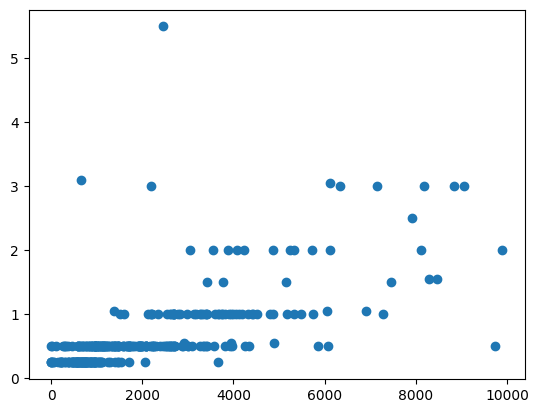

In [145]:
remove = np.where(df_train["real area (cm)"] > 12000)[0]

df_train.drop(remove, inplace=True)
df_train = df_train.dropna()
plt.scatter(x = df_train["real area (cm)"], y = df_train["Bags used "])

In [146]:
from sklearn.linear_model import LinearRegression
X = np.array(df_train["real area (cm)"]).reshape(-1, 1)
y = df_train["Bags used "]
linear_model = LinearRegression()
linear_model.fit(X, y)


LinearRegression()